In [33]:
import os
os.chdir( "/home/lucasfuzato/TCC/CODE" )

import torch as tc
device = "cuda" if tc.cuda.is_available() else "cpu"
print( device )

import torch.utils.data as tdt
import pandas as pd


from typing import *
from itertools import *
from src.util.aux_fun import *
from src.util.loader_data import meu_loader

import matplotlib.pyplot as plt

cpu


In [34]:
def data_iter( test : bool, batch_size : int = 500 , max_time = 1.):

    tup , _iter = None , None
    while True:

        if tup is None:
            _iter = iter(
                tdt.DataLoader( meu_loader( test , max_time = max_time ) , batch_size = batch_size , shuffle = True )
            )
            tup = next( _iter )
        
        yield tup

def evaluate_model( net , opm , num_iter = 2*( 10**4 ) , record_interval = 100 , **kwargs ):

    fit = fit_fun( net , opm )
    eval_f = eval_fun( net )
    train_data = data_iter( False , max_time = kwargs.get( "max_time" , 1. ))
    test_data = data_iter( True   , max_time = kwargs.get( "max_time" , 1. ))

    results = []
    for i in range( num_iter ):

        X_train , y_train = next( train_data )
        if not( i%record_interval ):

            ser = pd.Series( index = [ "iter" , "tr_loss" , "ts_loss" ] )
            ser[ "tr_loss" ] = eval_f( X_train , y_train )

            X_test , y_test = next( test_data )
            ser[ "ts_loss" ] = eval_f( X_test , y_test )

            ser[ "iter" ] = i
            results.append( ser )
        
        fit( X_train , y_train )
    
    return pd.DataFrame( results )

In [35]:

# Candidate architectures
shape_1 = [ 3 , 128 , 256 , 256 , 256 , 128 , 2 ]
shape_2 = [ 3 , 256 , 512 , 256 , 2 ]
shapes = [ "shape_1" , "shape_2" ]

# Activation functions ( internal )
act_1 = tnn.GELU
act_2 = tnn.Softplus
acts  = ["act_1" , "act_2"]

# learning rates
l_rates = [ 1e-4 , 1e-5 ]

# saving the grid
grid_search_instances = pd.DataFrame(
    list( product( shapes , acts , l_rates ) ),
    columns = [ "shape" , "act" , "lr" ]
)

# performance of each model
grid_search_instances[ "min_train" ] = np.nan # on the training set 
grid_search_instances[ "min_test"  ] = np.nan # on the test set

df_lst = []
nets   = []
n = len( grid_search_instances )
for j in range( n ):

    shape_name = grid_search_instances.at[ j , "shape" ]
    shape = globals()[ shape_name ]

    act_name = grid_search_instances.at[ j , "act" ]
    act = globals()[ act_name ]

    lr = grid_search_instances.at[ j , "lr" ]

    # evaluate the performance 
    net , opm = make_net( shape , act , lr = lr )
    results = evaluate_model( net , opm  )

    grid_search_instances.at[ j , "min_train" ] = results[ "tr_loss" ].min()
    grid_search_instances.at[ j , "min_test"  ] = results[ "ts_loss" ].min()

    df_lst.append( results )
    nets.append( net )

grid_search_instances.sort_values( by = [ "min_test"] , inplace = True )
print( grid_search_instances )

     shape    act       lr  min_train  min_test
7  shape_2  act_2  0.00001   0.029079  0.036675
3  shape_1  act_2  0.00001   0.014127  0.030879
0  shape_1  act_1  0.00010   0.004111  0.023522
6  shape_2  act_2  0.00010   0.008652  0.015943
5  shape_2  act_1  0.00001   0.006087  0.014103
4  shape_2  act_1  0.00010   0.003733  0.010451
2  shape_1  act_2  0.00010   0.004204  0.009338
1  shape_1  act_1  0.00001   0.003720  0.008314


1


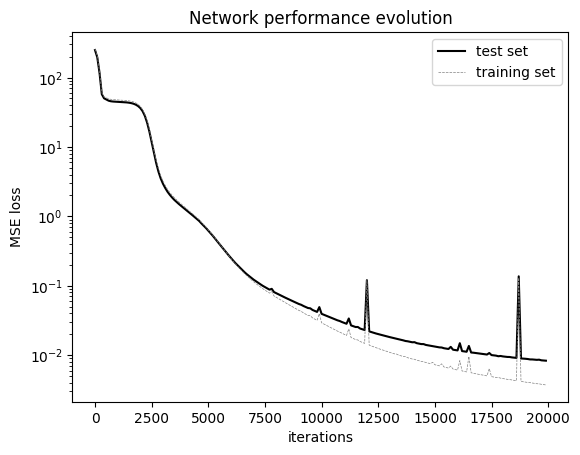

In [40]:
best = grid_search_instances.index[ -1 ]
print( best )

results = df_lst[ best ]
x_vals = results[ "iter" ].to_numpy()
loss_vals = results[ [ "tr_loss" , "ts_loss" ] ].to_numpy()

plt.plot( x_vals , loss_vals.T[ 1 ] , "-k" , label = "test set" )
plt.plot( x_vals , loss_vals.T[ 0 ] , color = "grey" , linestyle = "--", lw = .5 , label = "training set" )

plt.xlabel( "iterations" )
plt.ylabel( "MSE loss" )
plt.title( "Network performance evolution" )
plt.legend()

plt.yscale( "log" )
plt.show()

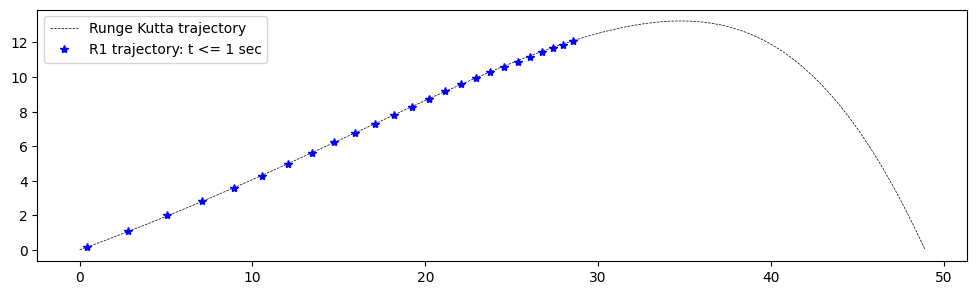

In [51]:
net = nets[ best ]
tr_df = pd.read_csv( TR_FILE )
cond_df = pd.read_csv( COND_FILE )
n_points = 25

def plot_trajectory( simmu_id ):

    # -------------------------------------------------
    # getting the real trajectory
    where = tr_df[ "simu_id" ] == simmu_id
    real_tr = tr_df.loc[ where ][ [ "x" , "y" ] ].to_numpy()
    real_x = real_tr.T[ 0 ]
    real_y = real_tr.T[ 1 ]

    #---------------------------------------------------
    init_cond = cond_df.loc[ simmu_id ]
    v_0 = init_cond[ "v_0"]
    theta_0 = init_cond[ "theta_0"]

    # network input
    X_input = tc.zeros( n_points , 3 , dtype = STD_TYPE , device = DEVICE )
    X_input[ : , 0 ] = theta_0
    X_input[ : , 1 ] = v_0
    X_input[ : , 2 ] = tc.linspace( 0 , 1. , n_points )

    # network estimated trajectory
    net_out = net( X_input ).cpu().detach().numpy()
    net_x = net_out.T[ 0 ]
    net_y = net_out.T[ 1 ]

    # ------------------------------------------------
    # plotting trajectories
    fig , ax = plt.subplots( figsize = ( 12 , 8 ))
    ax.set_aspect( "equal" )

    # real trajectory
    ax.plot( real_x, real_y , "--k" , lw = .5 , label = "Runge Kutta trajectory")
    ax.plot( net_x , net_y , "*b" , label = "R1 trajectory: t <= 1 sec" )

    plt.legend()
    plt.show()

plot_trajectory( 35 )

In [53]:
tc.save( net.state_dict() , "data/r1_net.pt" )

In [30]:
chosen_shape = shape_2
chosen_lr = 1e-5
chosen_act = act_2

times = [ .5 , 1. , 2.5 ]
performances = []
t_nets = []
for max_time in times:
    net , opm = make_net( chosen_shape , chosen_act , chosen_lr )
    result = evaluate_model( net , opm , max_time = max_time )

    performances.append( result )
    t_nets.append( net )


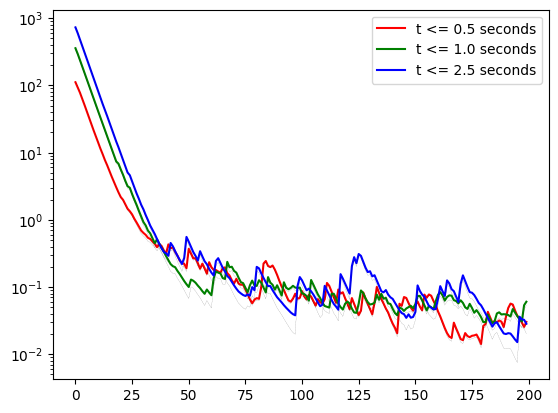

In [32]:
fmts = [ "-r" , "-g" , "-b" ]
for t , p , c in zip( times , performances , fmts ):

    losses = p[ [ "tr_loss" , "ts_loss" ] ].to_numpy()
    for i in range( 1 , len( losses ) ):
        losses[ i ] = losses[ i ]*.2 + losses[ i - 1 ]*.8
    tr_loss = losses.T[ 0 ]
    ts_loss = losses.T[ 1 ]
    
    plt.plot( p.index , ts_loss , c , label = f"t <= {t} seconds" )
    plt.plot( p.index , tr_loss , "--k" , lw = .1  )

plt.yscale( "log" )
plt.legend()
plt.show()

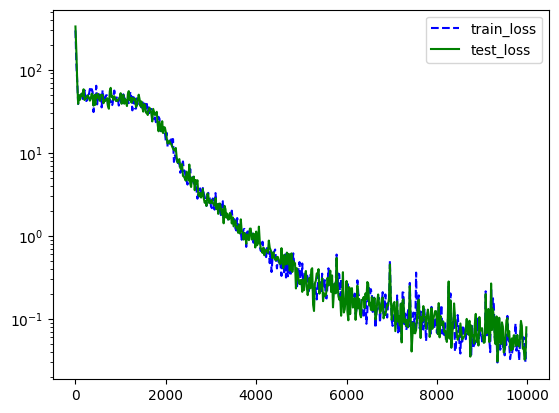

In [19]:
results_df = pd.DataFrame( results , columns = [ "train_loss" , "test_loss" ] )
results_df = results_df.iloc[ : : 20 ]
results_df.plot( style = {
    "test_loss":"-g",
    "train_loss":"--b"
})
plt.yscale( "log" )
plt.show()

tensor([4.5197, 1.2629], device='cuda:0', dtype=torch.float64)
tensor([4.2765, 1.4872], device='cuda:0', dtype=torch.float64,
       grad_fn=<AddBackward0>)
